In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import equity_plot
import lightgbm as lgb
from sklearn import metrics
from equity_plot import equity_plot
import datetime
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings('ignore')

#### Loading Data

In [2]:
merge_data_raw = pd.read_pickle('stock_dataset.pkl')

In [3]:
merge_data_raw['code'] = merge_data_raw['code'].astype(float)
# merge_data_raw.columns

#### Feature Engineer

In [4]:
## 股價區
merge_data = merge_data_raw.copy()

merge_data['intraday_ret'] = merge_data['收盤價(元)']/merge_data['開盤價(元)'] -1
merge_data['high_ret'] = merge_data['最高價(元)']/merge_data['開盤價(元)'] -1
merge_data['low_ret'] = merge_data['最低價(元)']/merge_data['開盤價(元)'] -1
merge_data['close_1'] = merge_data.groupby('code')['收盤價(元)'].shift(1)
merge_data['jump'] = merge_data['開盤價(元)']/merge_data['close_1'] -1

## 均線
merge_data = merge_data.sort_values(['code','date'])
merge_data['5ma_vol'] = merge_data.groupby(merge_data['code'])['收盤價(元)'].rolling(5).std().values
merge_data['5volume_vol'] = merge_data.groupby(merge_data['code'])['成交量(千股)'].rolling(5).std().values
merge_data['5ma_ret'] = merge_data.groupby(merge_data['code'])['報酬率％'].rolling(5).std().values

In [5]:
merge_data = merge_data[(merge_data['intraday_ret'] <= 0.101) &(merge_data['intraday_ret'] >= -0.101)].sort_values(['code','date'])

#### Ranking 

In [ ]:
# var_list_name = ['漲跌停', '報酬率％', '週轉率％', '注意股票(A)', '成交量(千股)', '融資增減比率', '融券增減比率',
#             'high_ret', 'low_ret', 'jump', '現股當沖比重', '現股當沖量(千股)','5ma_vol','5volume_vol','5ma_ret']

# for i in var_list_name :
#     merge_data[i+'_rank'] = merge_data.groupby(merge_data['date'])[i].rank("dense", ascending=False)
    
# merge_data.set_index('date',inplace = True)

In [ ]:
# unwant = ['code', 'date', '開盤價(元)', '最高價(元)', '最低價(元)', '收盤價(元)',
#           '最後揭示買價', '最後揭示賣價','借券賣出(千元)_交易所']

# var_list = [x for x in merge_data.columns if x not in unwant]

#### Modeling 

In [ ]:
merge_data['intraday_ret_led1'] = merge_data.groupby('code')['intraday_ret'].shift(-1)
# merge_data = merge_data.set_index('date')
# merge_data = merge_data.set_index('date')

In [ ]:
q33 = merge_data.intraday_ret_led1.quantile(q = 0.33)
q66 = merge_data.intraday_ret_led1.quantile(q = 0.66)
q50 = merge_data.intraday_ret_led1.quantile(q = 0.5)
print('Short : %f , Long : >= %f' %(q33,q66))
print('half : %f' %(q50))

In [ ]:
merge_data['trend'] = np.where(merge_data['intraday_ret_led1']>=q50 , 1 ,-1)

# merge_data['trend'] = np.where(merge_data['intraday_ret_led1']< q33 , -1 ,
#                                np.where(merge_data['intraday_ret_led1']>=q66,1,0))

In [ ]:
merge_data['trend'].hist()

In [ ]:
train_date = '2021-09-01'
test_date = '2021-09-10'
trainx = merge_data.loc[:train_date,var_list]
trainy = merge_data.loc[:train_date,'trend']
testx = merge_data.loc[test_date:,var_list]
testy = merge_data.loc[test_date:,'trend']

#回測資料
test_data = merge_data.loc[test_date:]
train_data = merge_data.loc[:train_date]

In [ ]:
model = lgb.LGBMClassifier(
                            objective = 'binary',
                            boosting_type='gbdt',
                            drop_rate = 0.8,
                            num_leaves=10,
                            max_depth=-1,
                            learning_rate=0.01,
                            n_estimators=400,
                            bagging_fraction = 0.7,
                            bagging_freq = 10)
model.fit(trainx,trainy)

In [ ]:
train_pred = model.predict(trainx)
train_pred_pra = model.predict_proba(trainx)

test_pred=model.predict(testx)
test_pred_pra = model.predict_proba(testx)

In [148]:
train_data['pred'] = train_pred
train_data['short_prob'] = pd.DataFrame(train_pred_pra).iloc[:,0].values
train_data['long_prob'] = pd.DataFrame(train_pred_pra).iloc[:,1].values

test_data['pred'] = test_pred
test_data['short_prob'] = pd.DataFrame(test_pred_pra).iloc[:,0].values
test_data['long_prob'] = pd.DataFrame(test_pred_pra).iloc[:,1].values

In [164]:
print("Accuracy on train:\t", metrics.accuracy_score(trainy, train_pred))
print("Precision on train:\t", metrics.precision_score(trainy, train_pred))
print("Recall on train:\t", metrics.recall_score(trainy, train_pred))
print("F1 on train:\t\t", metrics.f1_score(trainy, train_pred))
print('\n')
print("Accuracy on test:\t", metrics.accuracy_score(testy, test_pred))
print("Precision on test:\t", metrics.precision_score(testy, test_pred))
print("Recall on test:\t\t", metrics.recall_score(testy, test_pred))
print("F1 on test:\t\t", metrics.f1_score(testy, test_pred))

Accuracy on train:	 0.5673038612336894
Precision on train:	 0.5766669700607799
Recall on train:	 0.5399258728204851
F1 on train:		 0.557691944958884


Accuracy on test:	 0.5563299404773624
Precision on test:	 0.5587389949475086
Recall on test:		 0.49004935519821685
F1 on test:		 0.5221447857617438


In [124]:
print('訓練集資料Label : 資料時間(%s - %s)' %(train_data.index.min(),train_data.index.max()))
print(train_data['trend'].value_counts())
print('預測結果')
print(np.unique(train_pred,return_counts = True))
print('\n')

print('測試集資料Label : 資料時間(%s - %s)' %(test_data.index.min(),test_data.index.max()))
print(test_data['trend'].value_counts())
print('預測結果')
print(np.unique(test_pred,return_counts = True))

訓練集資料Label : 資料時間(2015-01-05 00:00:00 - 2021-09-01 00:00:00)
 1    739270
-1    723967
Name: trend, dtype: int64
預測結果
(array([-1,  1]), array([771068, 692169], dtype=int64))


測試集資料Label : 資料時間(2021-09-10 00:00:00 - 2022-05-10 00:00:00)
-1    77007
 1    75372
Name: trend, dtype: int64
預測結果
(array([-1,  1]), array([86273, 66106], dtype=int64))


#### Backtesting Frame

In [149]:
#Train
train_bt_pivot = train_data.reset_index().pivot_table(index = 'date',values = 'pred',columns = 'code')
train_short_prob_pivot = train_data.reset_index().pivot_table(index = 'date',values = 'short_prob',columns = 'code')
train_long_prob_pivot = train_data.reset_index().pivot_table(index = 'date',values = 'long_prob',columns = 'code')
train_intraday_pivot = train_data.reset_index().pivot_table(index = 'date',values = 'intraday_ret_led1',columns = 'code')
train_volume_pivot = train_data.reset_index().pivot_table(index = 'date',values = '成交量(千股)',columns = 'code')
train_vol_pivot = train_data.reset_index().pivot_table(index = 'date',values = '收盤價(元)',columns = 'code').rolling(5).std()
train_bt_time = train_bt_pivot.index


test_bt_pivot = test_data.reset_index().pivot_table(index = 'date',values = 'pred',columns = 'code')
test_short_prob_pivot = test_data.reset_index().pivot_table(index = 'date',values = 'short_prob',columns = 'code')
test_long_prob_pivot = test_data.reset_index().pivot_table(index = 'date',values = 'long_prob',columns = 'code')
test_intraday_pivot = test_data.reset_index().pivot_table(index = 'date',values = 'intraday_ret_led1',columns = 'code')
test_volume_pivot = test_data.reset_index().pivot_table(index = 'date',values = '成交量(千股)',columns = 'code')
test_vol_pivot = test_data.reset_index().pivot_table(index = 'date',values = '收盤價(元)',columns = 'code').rolling(5).std()
test_bt_time = test_bt_pivot.index

<AxesSubplot:title={'center':'intraday_ret_led1'}, xlabel='[prob_cut]'>

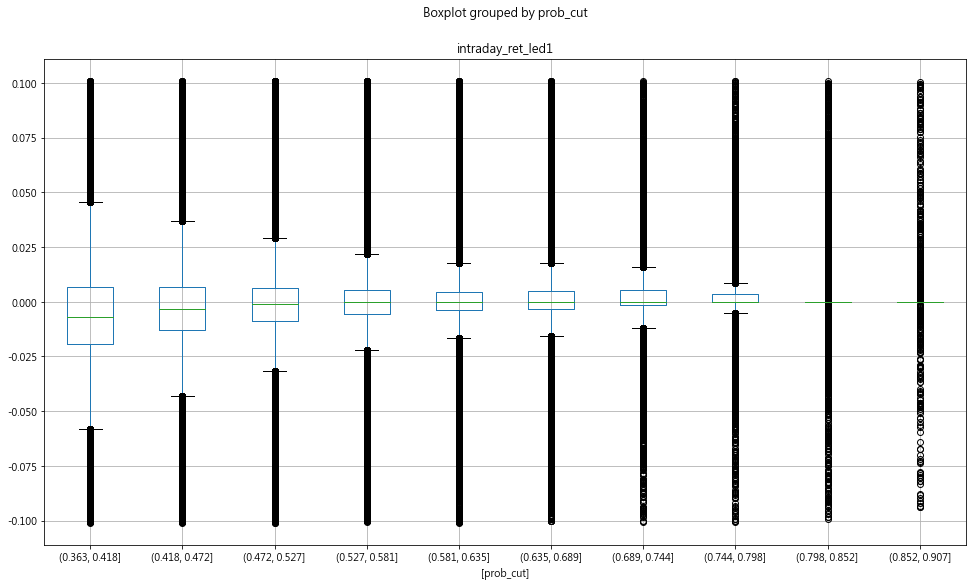

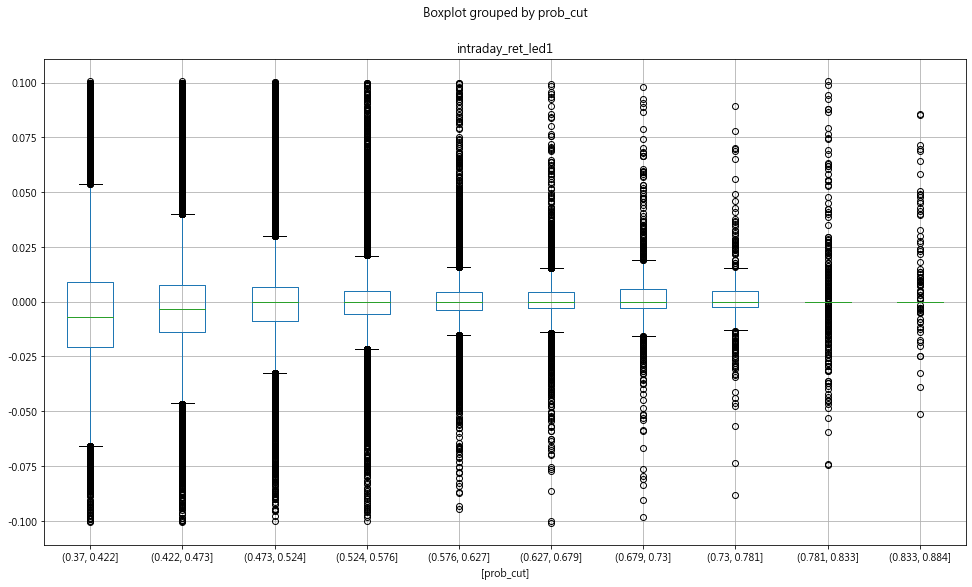

In [191]:
train_data['prob_cut'] = pd.cut(train_data['long_prob'],bins = 10)
test_data['prob_cut'] = pd.cut(test_data['long_prob'],bins = 10)

train_data[['intraday_ret_led1','prob_cut']].boxplot(by ='prob_cut' ,figsize = (16,9))
test_data[['intraday_ret_led1','prob_cut']].boxplot(by ='prob_cut' ,figsize = (16,9))

In [196]:
test_long_ret = {}
test_long_target = {}
train_long_ret = {}
train_long_target = {}
p = 0.53
fee = -0.001425*2-0.003
# fee = 0
for day in range(len(train_bt_time)) :
    
    train_long_stock_list = signal(train_bt_pivot,day,'+',p,train_long_prob_pivot,
                                   train_bt_time,train_volume_pivot,train_vol_pivot)
    
    train_long_ret[train_bt_time[day]] = ((train_intraday_pivot.loc[train_bt_time[day],train_long_stock_list].mean())*1)-fee
    train_long_target[train_bt_time[day]] = train_long_stock_list


for day in range(len(test_bt_time)-1) :
    
    test_long_stock_list = signal(test_bt_pivot,day,'+',p,test_long_prob_pivot,
                                   test_bt_time,test_volume_pivot,test_vol_pivot)
    
    test_long_ret[test_bt_time[day]] = ((test_intraday_pivot.loc[test_bt_time[day],test_long_stock_list].mean())*1)-fee
    test_long_target[test_bt_time[day]] = test_long_target
    

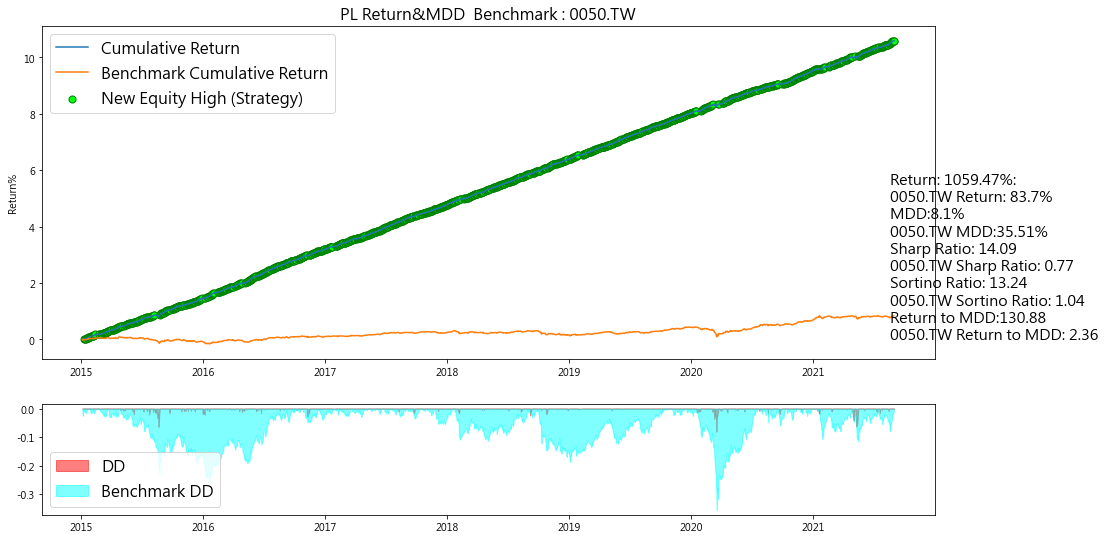

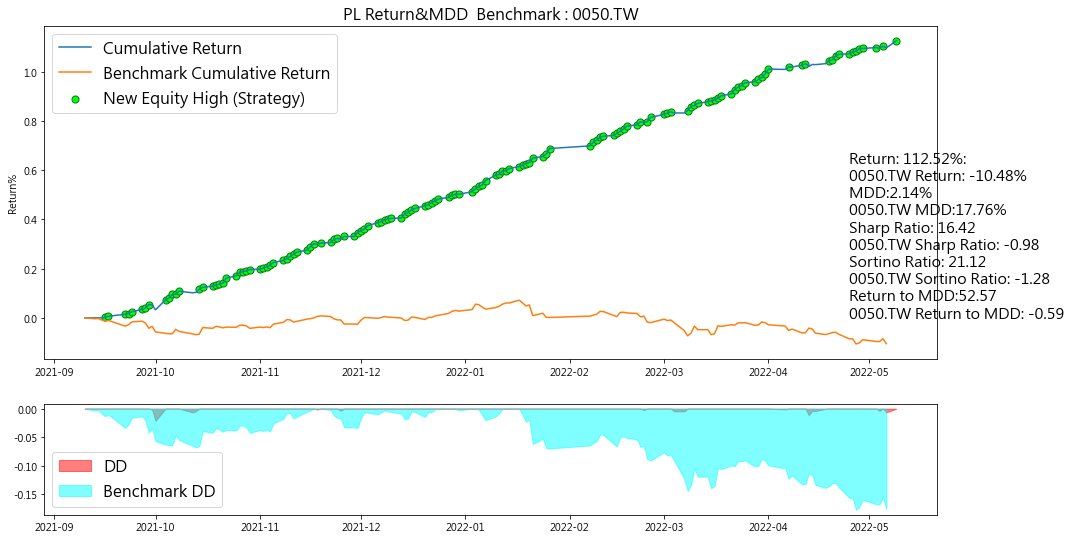

In [197]:
for i in [train_long_ret,test_long_ret] :
    equity_plot(pd.DataFrame([i]).T.fillna(0).cumsum(),'0050.TW','PL',1)

In [165]:
for day in range(len(test_bt_time)) :
    test_long_stock_list = signal(test_bt_pivot,day,'+',p,test_long_prob_pivot,
                                   test_bt_time,test_volume_pivot,test_vol_pivot)
    if day < len(test_bt_time) :
        if test_intraday_pivot.loc[test_bt_time[day],test_long_stock_list].sum() != 0 :
            print(test_intraday_pivot.loc[test_bt_time[day],test_long_stock_list])
    else :
        print(test_long_stock_list)

code
2915.0    0.011364
6505.0    0.006390
6477.0   -0.022364
5522.0   -0.024348
2330.0    0.000000
2108.0   -0.019669
Name: 2021-09-22 00:00:00, dtype: float64
code
4968.0   -0.047801
2330.0    0.011844
Name: 2021-09-23 00:00:00, dtype: float64
code
2915.0    0.041667
8454.0   -0.023881
Name: 2021-09-27 00:00:00, dtype: float64
code
6756.0   -0.057339
2486.0    0.058182
Name: 2021-09-29 00:00:00, dtype: float64
code
2330.0   -0.008635
6756.0    0.017327
Name: 2021-09-30 00:00:00, dtype: float64
code
3042.0   -0.043000
4739.0   -0.038095
3588.0   -0.012712
3016.0   -0.056287
3017.0   -0.017356
5608.0    0.018087
2603.0   -0.100877
6505.0   -0.016162
4919.0   -0.043307
2637.0   -0.067460
2481.0   -0.051462
2609.0   -0.100000
2612.0   -0.014388
2615.0    0.094937
3006.0   -0.077551
Name: 2021-10-01 00:00:00, dtype: float64
code
2401.0    0.053883
4961.0    0.086111
1795.0    0.014737
2603.0    0.060762
2637.0    0.036232
2031.0    0.042705
8016.0    0.061224
2609.0    0.075575
2038.0    

KeyError: Timestamp('2022-05-10 00:00:00')

#### function

In [195]:
def signal(df,date,direction,prob,prob_df,time_df,volume_df,vol_df) :
    
    if direction == '-' :
        stock = df.loc[time_df[date]][df.loc[time_df[date]] == -1].index
    if direction == '+' :
        stock = df.loc[time_df[date]][df.loc[time_df[date]] == 1].index
    
    prob = prob_df.loc[time_df[date]][prob_df.loc[time_df[date]] >= prob].index
    volume = volume_df.loc[time_df[date]][volume_df.loc[time_df[date]] >= 3000].index
#     vol = vol_df.loc[time_df[date]][vol_df.loc[time_df[date]] >= 2].index
    
#     volume = volume_df.loc[time_df[date]][volume_df.loc[time_df[date]] >= 0].index
    vol = vol_df.loc[time_df[date]][vol_df.loc[time_df[date]] >= 0].index
    
    return set(stock)&set(prob)&set(volume)&set(vol)